#Labwork 4

In [1]:
import numpy as np
from numba import cuda, jit
from time import time
import matplotlib.pyplot as plt

In [3]:
# Load image
img = plt.imread('/content/wolf_big.jpg')

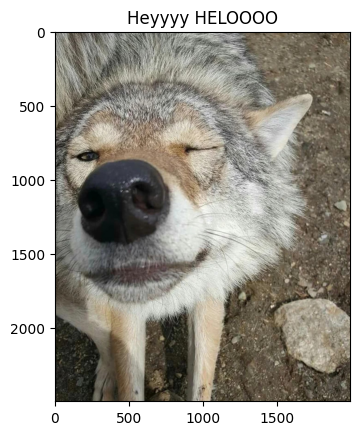

In [4]:
# Display the original image
plt.figure()
plt.imshow(img)
plt.title('Heyyyy HELOOOO')
plt.show()

In [5]:
def rgb2gray_cpu(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

In [6]:
@cuda.jit
def rgb2gray_cuda_2d(input_image, output_image):
    x, y = cuda.grid(2)
    if x < input_image.shape[0] and y < input_image.shape[1]:
        r = input_image[x, y, 0]
        g = input_image[x, y, 1]
        b = input_image[x, y, 2]
        # Apply the RGB to grayscale formula
        output_image[x, y] = 0.2989 * r + 0.5870 * g + 0.1140 * b

In [7]:
pixelCount = img.shape[0] * img.shape[1]
print(pixelCount)
flat_img = img.reshape(pixelCount, 3).astype(np.float32)
print(flat_img)

4995501
[[139. 140. 135.]
 [141. 142. 137.]
 [139. 140. 135.]
 ...
 [ 59.  52.  34.]
 [ 58.  51.  33.]
 [ 58.  51.  33.]]


In [8]:
# Grayscale with CPU
start_cpu = time()  # Start timing
gray_cpu = rgb2gray_cpu(img)
end_cpu = time()  # End timing
print(f"CPU processing time: {end_cpu - start_cpu:.6f} seconds")

CPU processing time: 0.148201 seconds


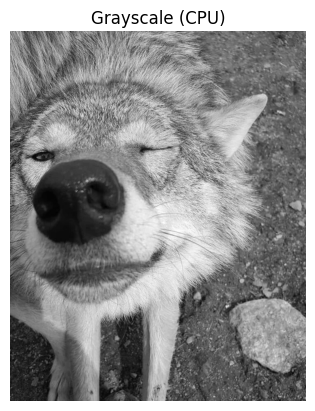

In [9]:
# Display CPU result
plt.imshow(gray_cpu, cmap='gray')
plt.title("Grayscale (CPU)")
plt.axis('off')
plt.show()

In [18]:
# GPU processing
dev_input = cuda.to_device(img.astype(np.float32))
dev_output = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.float32)

# Config blocks and grids
blockSize = (32, 32)
gridSize = (img.shape[0] // blockSize[0] + 1, img.shape[1] // blockSize[1] + 1)

In [19]:
# Grayscale with GPU
start_gpu = time()  # Start timing
rgb2gray_cuda_2d[gridSize, blockSize](dev_input, dev_output)
cuda.synchronize()  # Ensure GPU has completed
end_gpu = time()  # End timing
print(f"GPU processing time: {end_gpu - start_gpu:.6f} seconds")

GPU processing time: 0.005883 seconds


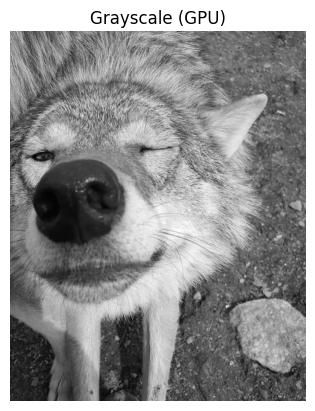

In [20]:
# Copy result back to host
gray_gpu = dev_output.copy_to_host().reshape(img.shape[0], img.shape[1])

# Display GPU result
plt.imshow(gray_gpu, cmap='gray')
plt.title("Grayscale (GPU)")
plt.axis('off')
plt.show()

In [21]:
# Calculate speedup
speedup = (end_cpu - start_cpu) / (end_gpu - start_gpu)
print(f"Speedup: {speedup:.2f}x")

Speedup: 25.19x
